In [5]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import pprint
import inspect  # <--- ADD THIS LINE
from IPython.display import display, Markdown

# --- 1. PANDAS & IPYTHON OPTIONS ---
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 3000)
pd.set_option('display.float_format', '{:.6f}'.format)
%load_ext autoreload
%autoreload 2

# --- 2. PROJECT PATH CONFIGURATION ---
NOTEBOOK_DIR = Path.cwd()
PARENT_DIR = NOTEBOOK_DIR.parent
ROOT_DIR = NOTEBOOK_DIR.parent.parent  # Adjust if your notebook is in a 'notebooks' subdirectory
DATA_DIR = ROOT_DIR / 'data'
SRC_DIR = ROOT_DIR / 'src'

# Add 'src' to the Python path to import custom modules
if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

# --- 3. IMPORT CUSTOM MODULES ---
import utils
import plotting_utils

# --- 4. INITIAL_CAPITAL ---
INITIAL_CAPITAL = 100000

# --- 5. RISK FREE ANNUAL RATE ---
RISK_FREE_ANNUAL_RATE = 0.04

# --- 6. VERIFICATION ---
print("--- Path Configuration ---")
print(f"✅ Project Root: {ROOT_DIR}")
print(f"✅ Parent Dir:   {PARENT_DIR}")
print(f"✅ Notebook Dir: {NOTEBOOK_DIR}")
print(f"✅ Data Dir:     {DATA_DIR}")
print(f"✅ Source Dir:   {SRC_DIR}")
assert all([ROOT_DIR.exists(), DATA_DIR.exists(), SRC_DIR.exists()]), "A key directory was not found!"

print("\n--- Module Verification ---")
print(f"✅ Successfully imported 'utils' and 'plotting_utils'.")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
--- Path Configuration ---
✅ Project Root: c:\Users\ping\Files_win10\python\py311\stocks
✅ Parent Dir:   c:\Users\ping\Files_win10\python\py311\stocks\notebooks_PyPortfOpt
✅ Notebook Dir: c:\Users\ping\Files_win10\python\py311\stocks\notebooks_PyPortfOpt\_working
✅ Data Dir:     c:\Users\ping\Files_win10\python\py311\stocks\data
✅ Source Dir:   c:\Users\ping\Files_win10\python\py311\stocks\src

--- Module Verification ---
✅ Successfully imported 'utils' and 'plotting_utils'.


DataFrame loaded successfully with 'Date' as index:
            Portfolio       VGT
Date                           
2016-02-01   0.001985  0.002453
2016-02-02  -0.009030 -0.020259
2016-02-03   0.002505 -0.002297
2016-02-04  -0.002031  0.002403
2016-02-05  -0.014716 -0.037456

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1770 entries, 2016-02-01 to 2023-02-09
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Portfolio  1770 non-null   float64
 1   VGT        1770 non-null   float64
dtypes: float64(2)
memory usage: 41.5 KB


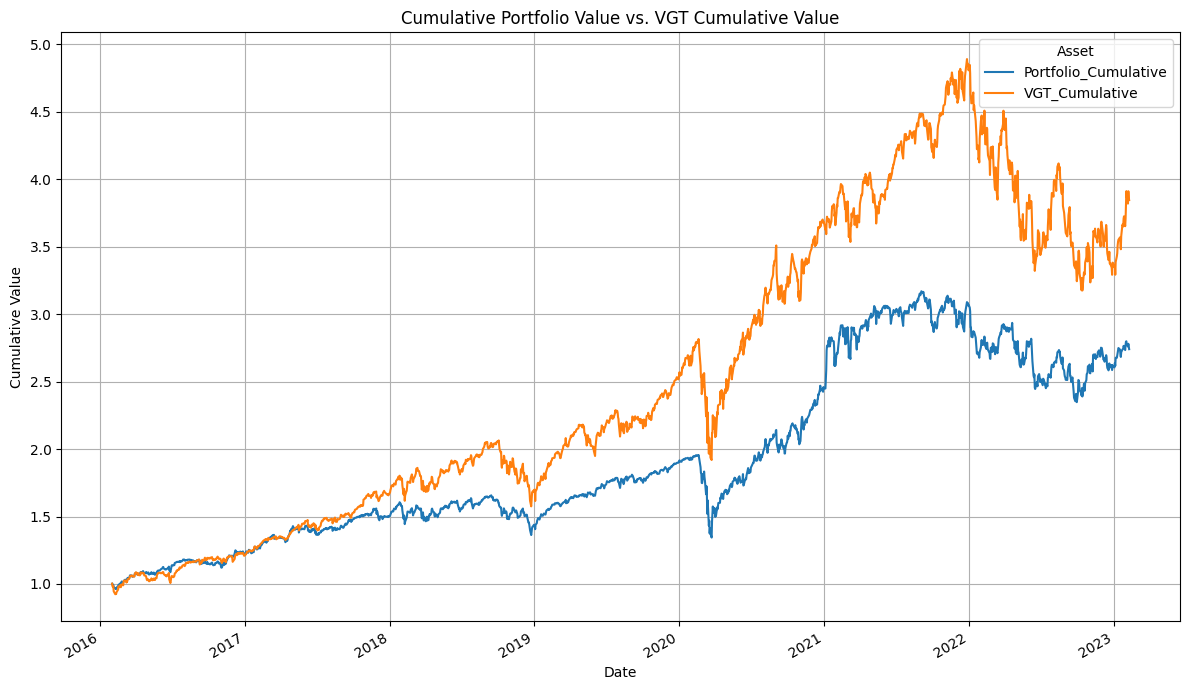


--- Sharpe Ratio Calculation ---
Annual Risk-Free Rate Used: 4.00%
Trading Days per Year Assumed: 252
------------------------------
Portfolio Sharpe Ratio: 0.6404
VGT Sharpe Ratio:       0.7330


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Load Data (assuming 'Date' is the index and parsed as datetime) ---
# csv_file_path = NOTEBOOK_DIR / "temp" / "portfolio_daily_return.csv"
csv_file_path = NOTEBOOK_DIR / "temp" / "portfolio_daily_return_5b_portfolio_all_higher_sharpe.csv"

try:
    df = pd.read_csv(
        csv_file_path,
        index_col='Date',
        parse_dates=True
    )
    print("DataFrame loaded successfully with 'Date' as index:")
    print(df.head())
    print("\nDataFrame Info:")
    df.info()

except FileNotFoundError:
    print(f"Error: The file '{csv_file_path}' was not found.")
    print("Please ensure 'portfolio_daily_return.csv' is in the correct directory.")
    exit() # Exit if the file isn't found
except Exception as e:
    print(f"An error occurred during CSV loading or date parsing: {e}")
    print("Please check the CSV format and date column.")
    exit()


# Calculate the cumulative returns for the portfolio and 'VGT'
df['Portfolio_Cumulative'] = (1 + df['Portfolio']).cumprod()
df['VGT_Cumulative'] = (1 + df['VGT']).cumprod()


# --- 2. Plotting Cumulative Values ---

plt.figure(figsize=(12, 7))
df[['Portfolio_Cumulative', 'VGT_Cumulative']].plot(ax=plt.gca()) # Plot directly from DataFrame
plt.title('Cumulative Portfolio Value vs. VGT Cumulative Value')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.grid(True)
plt.legend(title='Asset')
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

# --- 3. Calculate Sharpe Ratio ---

# Define key parameters for Sharpe Ratio
annual_risk_free_rate = 0.04  # Example: 2% annual risk-free rate. Adjust as needed.
trading_days_per_year = 252   # Standard number of trading days in a year

print("\n--- Sharpe Ratio Calculation ---")

# Calculate daily returns for both columns
# .pct_change() calculates percentage change from the previous row
# .dropna() removes the first row which will be NaN (no previous value)
portfolio_daily_returns = df['Portfolio_Cumulative'].pct_change().dropna()
vgt_daily_returns = df['VGT_Cumulative'].pct_change().dropna()

# Calculate average daily excess return (daily return - daily risk-free rate)
# Convert annual risk-free rate to daily rate
daily_risk_free_rate = annual_risk_free_rate / trading_days_per_year

portfolio_excess_return_daily_avg = portfolio_daily_returns.mean() - daily_risk_free_rate
vgt_excess_return_daily_avg = vgt_daily_returns.mean() - daily_risk_free_rate

# Calculate standard deviation of daily returns
portfolio_std_dev_daily = portfolio_daily_returns.std()
vgt_std_dev_daily = vgt_daily_returns.std()

# Calculate annualized Sharpe Ratio
# Sharpe Ratio = (Average Daily Excess Return / Daily Standard Deviation) * sqrt(Trading Days per Year)
sharpe_portfolio = (portfolio_excess_return_daily_avg / portfolio_std_dev_daily) * np.sqrt(trading_days_per_year)
sharpe_vgt = (vgt_excess_return_daily_avg / vgt_std_dev_daily) * np.sqrt(trading_days_per_year)


print(f"Annual Risk-Free Rate Used: {annual_risk_free_rate:.2%}")
print(f"Trading Days per Year Assumed: {trading_days_per_year}")
print("-" * 30)
print(f"Portfolio Sharpe Ratio: {sharpe_portfolio:.4f}")
print(f"VGT Sharpe Ratio:       {sharpe_vgt:.4f}")